Dataset Summary:

TweetEval consists of seven heterogenous tasks in Twitter, all framed as multi-class tweet classification. The tasks include - irony, hate, offensive, stance, emoji, emotion, and sentiment. All tasks have been unified into the same benchmark, with each dataset presented in the same format and with fixed training, validation and test splits.

Сводка набора данных

TweetEval состоит из семи разнородных задач в Twitter, каждая из которых представляет собой многоклассовую классификацию твитов. Задачи включают в себя: иронию, ненависть, оскорбление, позицию, смайлики, эмоции и настроения. Все задачи были объединены в один тест для каждого набора данных. представлены в том же формате и с фиксированным разделением на обучение, проверку и тестирование.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset


dataset = load_dataset("tweet_eval",  "sentiment" )
print(dataset)
#выбрал часть SENTIMENT из этого набора данных, в котором есть только 3 классификации для этой части метки. 
#Память компьютера невелика, и 20 классификаций будет недостаточно.

D:\Program Files\anaconda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


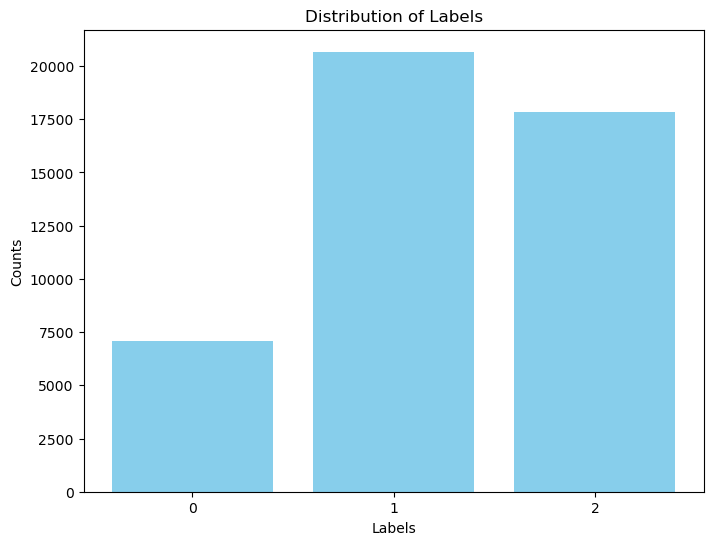

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

#показывает типы label и количество каждого типа.
label_counts = Counter(dataset['train']['label'])
label_categories = list(label_counts.keys())
label_values = list(label_counts.values())


plt.figure(figsize=(8, 6))
plt.bar(label_categories, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels')
plt.xticks(label_categories)
plt.show()

#0:negative ; 1:neutral ; 2:positive 

In [2]:
train_subset = dataset["train"].shuffle(seed=42).select(range(500))
test_subset = dataset["test"].shuffle(seed=42).select(range(500))


Поскольку объем памяти моего компьютера составляет всего 6 Гб, если данных будет слишком много, обученная модель будет иметь много параметров, и последующие интерпретации LIME и SHAP покажут, что памяти процессора недостаточно.
Поэтому здесь я выбираю только 500 данных для обучения.

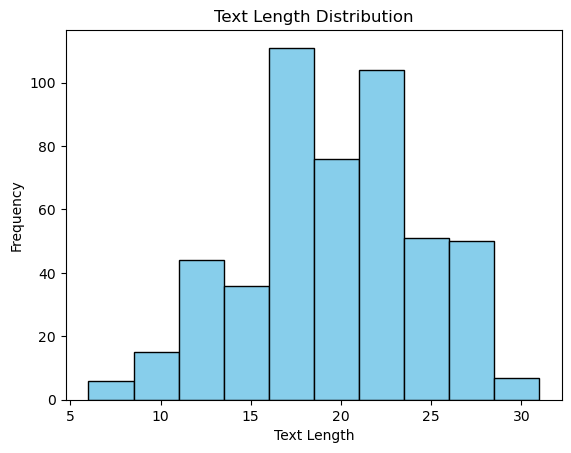

In [4]:
from wordcloud import WordCloud

#подсчитал распределение длины ТЕКСТА
text_lengths = [len(text.split()) for text in train_subset['text']]
plt.hist(text_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()


видим, что длина текста в основном составляет около 20

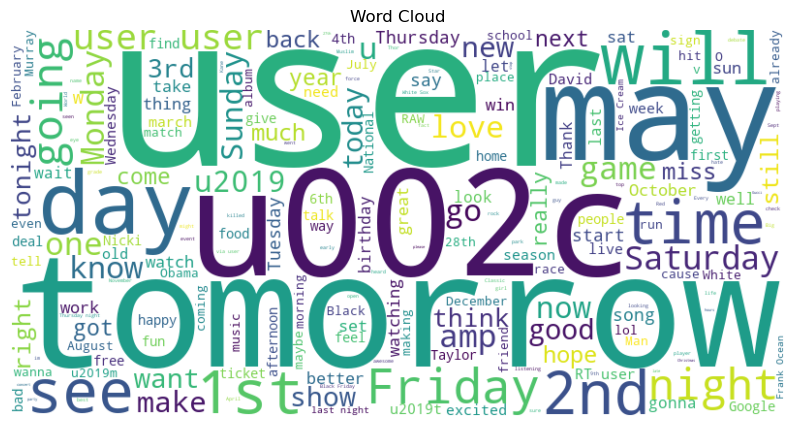

In [5]:
all_text = ' '.join(train_subset['text'])

# сгенерированное облако слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


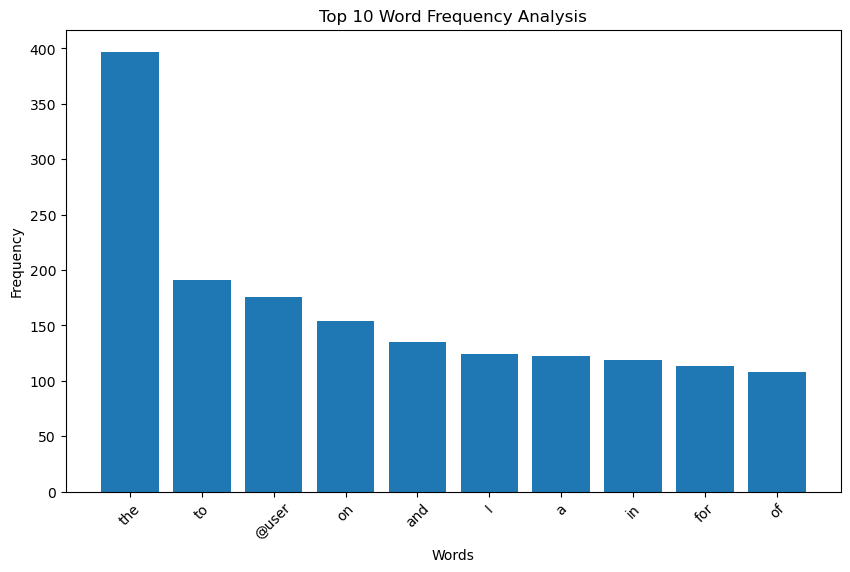

In [6]:
# Показывает 10 слов с наибольшей частотой употребления
words = all_text.split()
top_words = dict(Counter(words).most_common(10))

labels = list(top_words.keys())
values = list(top_words.values())


plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency Analysis')
plt.xticks(rotation=45)
plt.show()


In [4]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import numpy as np
import scipy as sp
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

import shap

# load a DistilBERT model
#DistilBERT is a smaller and faster version of the BERT model,У него меньше параметров, чем у BERT.
tokenizer =  DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight

In [5]:
print(test_subset[:10])

{'text': ['@user @user @user @user but some of the reviews are good.', 'US electoral college a rubber stamp, says Talbott #news #timesofindia', "@user @user well traditionally we don't vote rightists into power. And are too fragmented to elect a trump or modi", '@user @user why did trump appoint Steve Bannon in his cabinet who openly racism and support KKK.This guy will save th wrld?', 'AI and robots line up for battlefield service via @user', 'Galaxy Note 7 Banned In U.S. Flights & Violators Will Be Sent To Prison', 'You can still sign up for the evening seminar on #dronestrikes in counter-terror wars 14 December  #TheHague @user', 'Is Ukraine headed for another revolution? via @user #saakashvili', 'RIP EU Persona 5 PSN theme  ;_;   ;_;   ;_;The ride never ends for Europe', 'I bought a guy a Valentines Day gift once and that was really traumatic for me so I try my best to be single on gift giving holidays.'], 'label': [2, 1, 0, 0, 1, 0, 1, 1, 1, 1]}


In [6]:
def encode(examples):
#     temp = examples['text']
#     temp = temp.replace('#', '')
#Иногда символ "#" влияет на оценку модели, поэтому можем удалить этот символ совсем
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64)

# Преобразовать текст в вектор
train_encoded = train_subset.map(encode, batched=True)
test_encoded = test_subset.map(encode, batched=True)


training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=1,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    warmup_steps=500,               
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded,  
    eval_dataset=test_encoded     
)
#Модели обучения
trainer.train()



Map: 100%|██████████| 500/500 [00:00<00:00, 2723.43 examples/s]
Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)


TrainOutput(global_step=63, training_loss=1.1016221122136192, metrics={'train_runtime': 3.878, 'train_samples_per_second': 128.934, 'train_steps_per_second': 16.246, 'total_flos': 8279360064000.0, 'train_loss': 1.1016221122136192, 'epoch': 1.0})

# Интерпретация с помощью LIME

## Выбираем позитивный текст для анализа

In [7]:
print(test_subset[:5])        
selected_indices = np.where((np.array(test_subset['label']) == 2) & (np.array([len(text.split()) for text in test_subset['text']]) < 13))[0]

print("приемлемый индекс:", selected_indices)
#Мы ищем индекс, который соответствует условиям, label=2 и имеет длину меньше 13 
#(слишком большая длина приведет к нехватке памяти cuda).

{'text': ['@user @user @user @user but some of the reviews are good.', 'US electoral college a rubber stamp, says Talbott #news #timesofindia', "@user @user well traditionally we don't vote rightists into power. And are too fragmented to elect a trump or modi", '@user @user why did trump appoint Steve Bannon in his cabinet who openly racism and support KKK.This guy will save th wrld?', 'AI and robots line up for battlefield service via @user'], 'label': [2, 1, 0, 0, 1]}
приемлемый индекс: [  0  12  25  43  44  60  66  68  75  77  89  91  95  98 101 112 114 120
 121 125 141 146 160 161 182 191 208 225 231 243 262 263 266 268 289 294
 307 311 380 385 389 391 400 402 419 425 426 431 432 440 446 458 476 481
 489 498]


In [8]:
print(test_subset[25])

{'text': "They'll remember this night forever. #ThisIsUs", 'label': 2}


In [9]:
explainer = LimeTextExplainer(class_names=["0", "1","2"])  # Initialize LIME Text Explainer

def predict_proba(texts):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: tensor.to('cuda') for key, tensor in inputs.items()}
#Поскольку параметры модели находятся в cuda, необходимо сохранить текст в cuda.
        outputs = model(**inputs)
        predictions = outputs.logits.softmax(dim=-1).detach().cpu().numpy()  # Move predictions to CPU
    return predictions

text_to_explain = test_subset['text'][25]
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=5,top_labels=2,labels=[0, 1, 2])
#找到对结果影响最大的5个词

In [10]:
print(exp.as_list())

[('forever', -0.003811989929117824), ('night', -0.0025860787709842507), ('remember', -0.0016046282338318982), ('ll', -0.0013825992000401363), ('They', 0.0010485137916203585)]


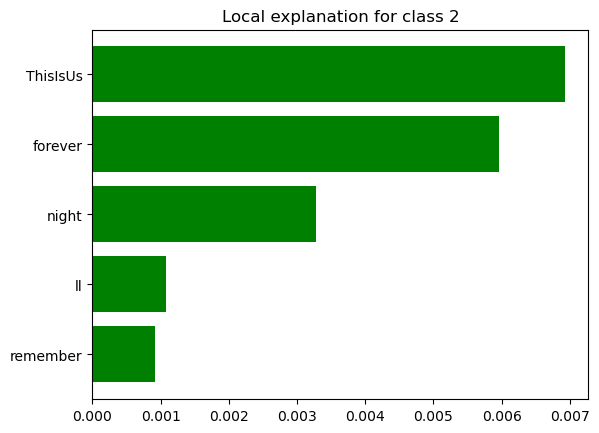

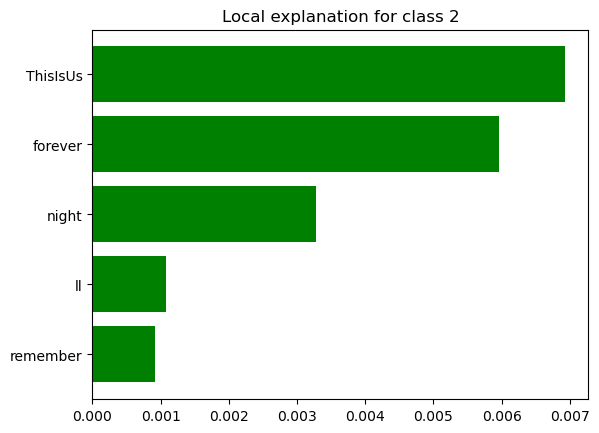

In [11]:
exp.as_pyplot_figure(label=2)

На этом графике видно, что "ThisIsUs" оказывает наибольшее положительное влияние на результаты.

In [12]:
print(test_subset[25])
exp.show_in_notebook()

{'text': "They'll remember this night forever. #ThisIsUs", 'label': 2}


Первая картинка: Вероятность того, что этот текст относится к категории 0, составляет 0,28; вероятность отнесения к категории 1 - 0,35; вероятность отнесения к категории 2 - 0,37. Итак, вероятность отнесения категории 2 оказалась наибольшей, поэтому этот текст классифицируется как 2 (положительный).

Вторая картинка: 

Слева - это тексты, не относящиеся к категории 2, справа - тексты, относящиеся к категории 2. Можно заметить, что "thisisus" оказывает наибольшее положительное воздействие на отнесение категории 2. Поскольку влияние каждого слова на метку очень мало, примерно 0,0001, на этой картинке оно отображается как 0,00. Точность этой картинки составляет всего 0,01.

text with highlighted words:Каждое слово подсвечено, и выделение зеленого цвета (зеленый цвет обозначает категорию 2). Чем темнее цвет, тем больше влияние этого слова.

## выбираем нейтральный текст для анализа

In [13]:
selected_indices = np.where((np.array(test_subset['label']) == 1) & (np.array([len(text.split()) for text in test_subset['text']]) < 13))[0]
print("приемлемый индекс:", selected_indices)

приемлемый индекс: [  1   4   7  15  23  24  37  49  59  67  72  76  78  92  96 106 110 115
 126 127 135 140 145 151 152 162 174 184 187 188 195 197 201 202 205 219
 229 232 241 249 251 252 270 276 286 287 290 297 299 310 315 316 321 329
 330 333 334 340 346 349 354 355 368 383 388 394 398 399 401 405 409 410
 412 415 420 429 430 436 441 444 448 449 455 456 457 460 465 467 475 482
 485 491]


In [14]:
print(test_subset['text'][1])

US electoral college a rubber stamp, says Talbott #news #timesofindia


In [15]:
text_to_explain = test_subset['text'][1]
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=5,top_labels=2)
print(exp.as_list())

[('electoral', 0.00808182335200657), ('stamp', -0.0029786109537156317), ('college', 0.0029262550532414976), ('news', 0.0029159626362014615), ('timesofindia', 0.002781617810123431)]


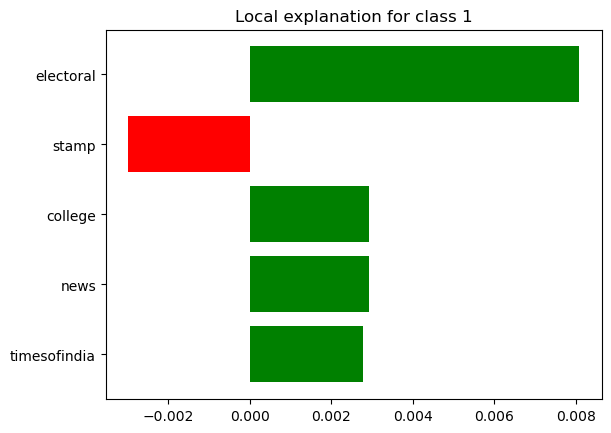

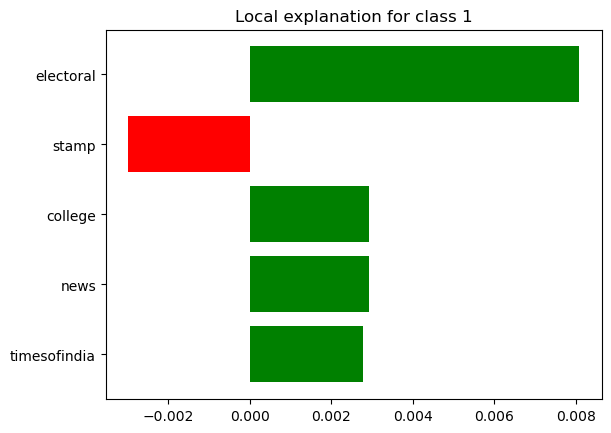

In [16]:
exp.as_pyplot_figure(label=1)

In [17]:
print(test_subset[1])
exp.show_in_notebook()

{'text': 'US electoral college a rubber stamp, says Talbott #news #timesofindia', 'label': 1}


Слово electoral оказывает наибольшее влияние на текст, относящийся к 1.

# Интерпретация с помощью SHAP

In [21]:
# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val


# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

shap_values = explainer(test_subset['text'][:20], fixed_context=1)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Partition explainer: 21it [00:10,  5.39s/it]                


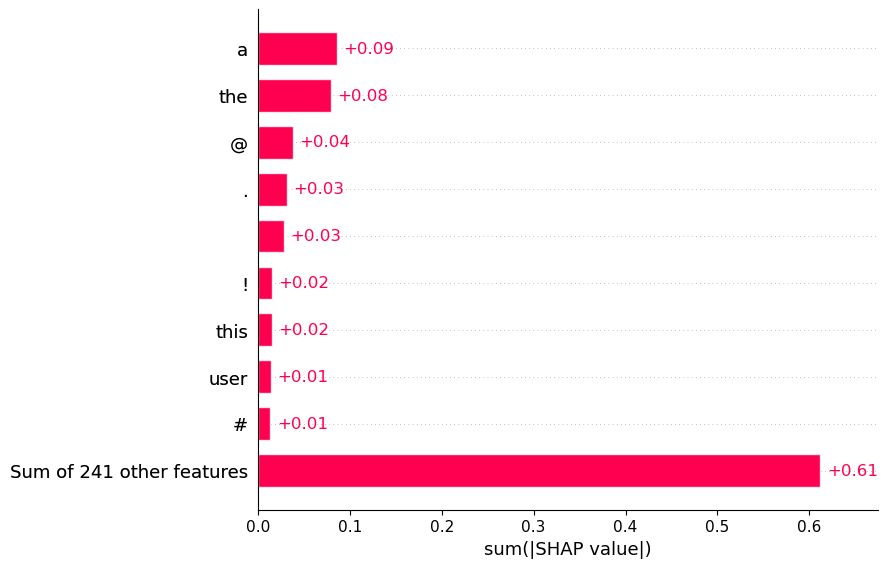

In [22]:
shap.plots.bar(shap_values.abs.sum(0)) # Резюме модели

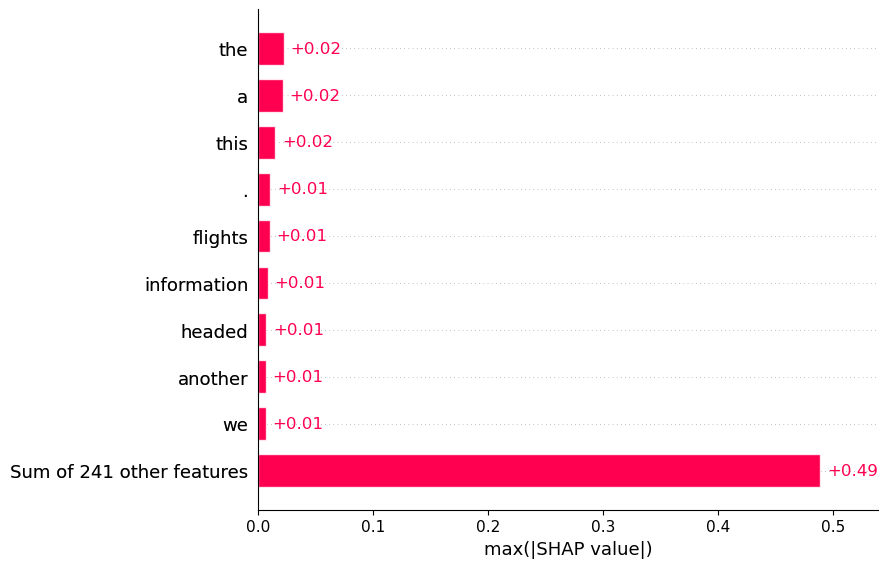

In [23]:
shap.plots.bar(shap_values.abs.max(0))

In [24]:
print(test_subset[:20])

{'text': ['@user @user @user @user but some of the reviews are good.', 'US electoral college a rubber stamp, says Talbott #news #timesofindia', "@user @user well traditionally we don't vote rightists into power. And are too fragmented to elect a trump or modi", '@user @user why did trump appoint Steve Bannon in his cabinet who openly racism and support KKK.This guy will save th wrld?', 'AI and robots line up for battlefield service via @user', 'Galaxy Note 7 Banned In U.S. Flights & Violators Will Be Sent To Prison', 'You can still sign up for the evening seminar on #dronestrikes in counter-terror wars 14 December  #TheHague @user', 'Is Ukraine headed for another revolution? via @user #saakashvili', 'RIP EU Persona 5 PSN theme  ;_;   ;_;   ;_;The ride never ends for Europe', 'I bought a guy a Valentines Day gift once and that was really traumatic for me so I try my best to be single on gift giving holidays.', '@user @user Your mother should have had a medical plan that included abortio

## Выбираем позитивный текст для анализа

In [25]:
shap.plots.text(shap_values[17])

In [26]:
print(test_subset[17])

{'text': "I will go so far to say s1 of westworld isn't just good, it's brilliant. A story within a story within a story about storytelling", 'label': 2}


Мы можем считать, что этот предложение классифицировано как 2, где красные слова оказывают положительное влияние("world","brilliant"), а синие слова — отрицательное("it","a").

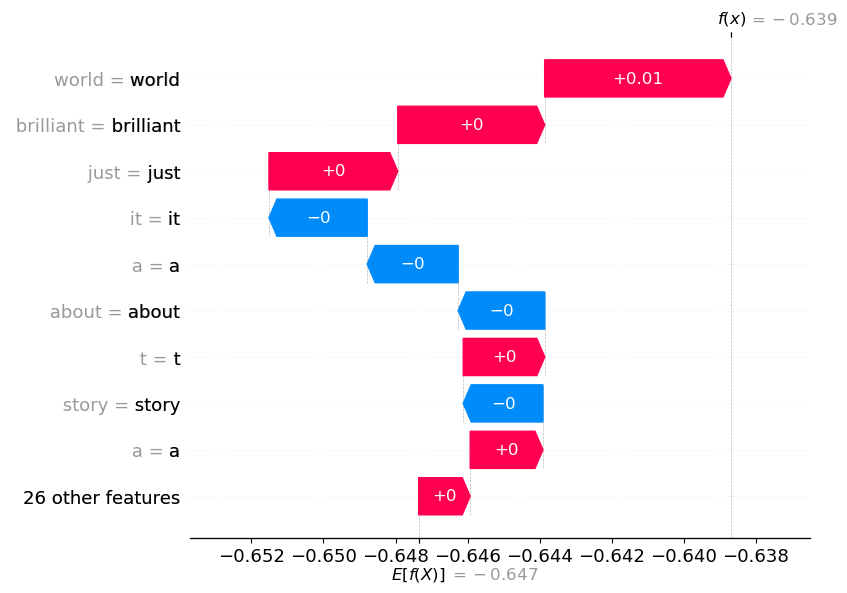

In [27]:
shap.plots.waterfall(shap_values[17])

## выбираем нейтральный текст для анализа

In [28]:
shap.plots.text(shap_values[1])

In [29]:
print(test_subset[1])

{'text': 'US electoral college a rubber stamp, says Talbott #news #timesofindia', 'label': 1}


Данный график показывает, что наибольшее положительное влияние на результаты(label=1) текста, оказывает слово "electoral". За ним следуют "stamp". 

Наибольшее отрицательное влияние на текст оказывает слово "a" .

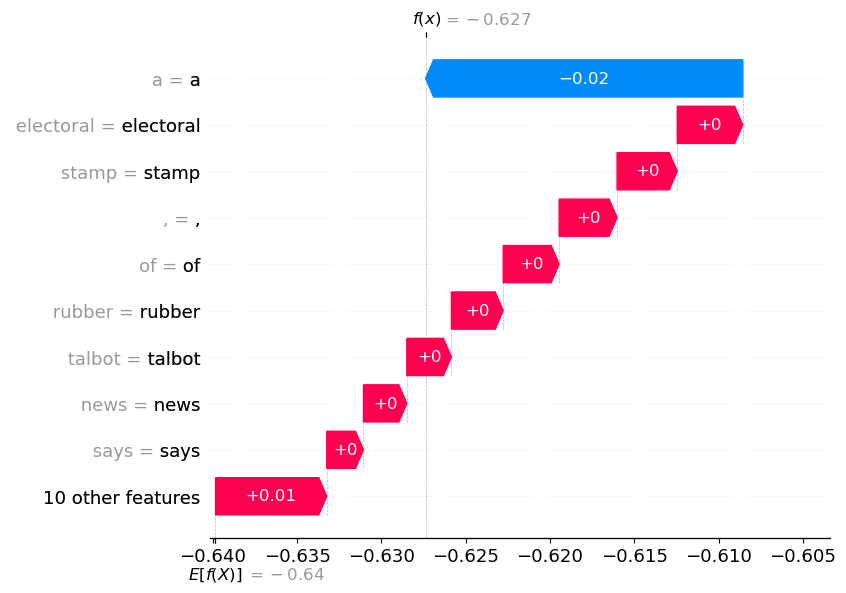

In [30]:
shap.plots.waterfall(shap_values[1])


## выбираем негативный текст для объяснения

In [31]:
shap.plots.text(shap_values[3])

In [32]:
print(test_subset[3])

{'text': '@user @user why did trump appoint Steve Bannon in his cabinet who openly racism and support KKK.This guy will save th wrld?', 'label': 0}


Данный график показывает, что наибольшее положительное влияние на результаты(label=0) текста, оказывает слово "guy","steve". 

Наибольшее отрицательное влияние на текст оказывает слово "this".

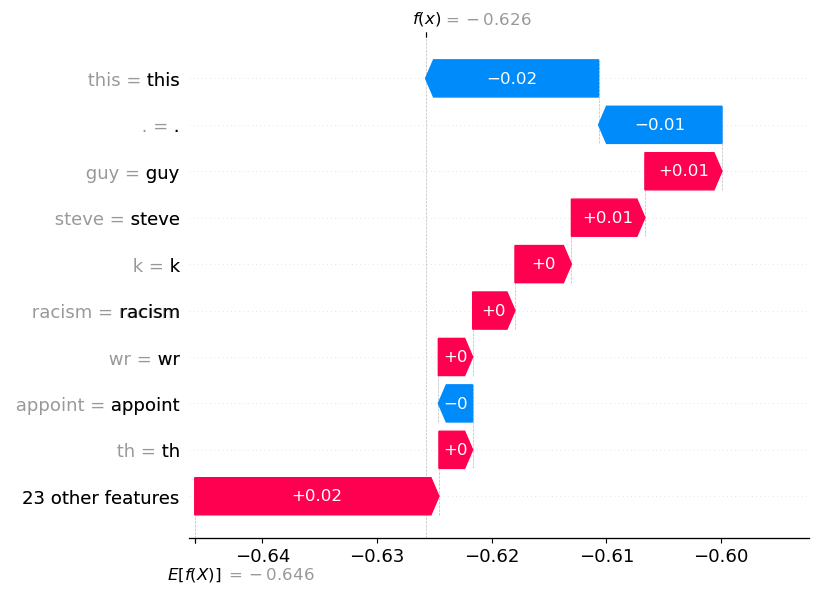

In [33]:
shap.plots.waterfall(shap_values[3])
